<a href="https://colab.research.google.com/github/ziatdinovmax/AISTEM_WORKSHOP_2020/blob/main/Day02/04b_BNNferro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian neural network for predicting functionality (polarization) from unit cell images

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com


---
In the Bayesian neural network (BNN), the neural network parameters $W$ (weights and biases) are represented by a prior probability distribution $p(W)$ instead of a single value (point estimate). Performing inference on the BNN calculates the posterior distribution $P(W|D)$ over the network parameters given the observations $D = {(x_1, y_1), . . .(x_N , y_N )}$. The major advantages of BNN over a standard neural network are that it allows modeling uncertainty of the training procedure and that it has a built-in weights regularization, that can be controlled by choosing different priors over the weights, preventing overfitting.

<img src="https://drive.google.com/uc?export=view&id=18jDerymT6GFSRgwSImI7KkLFM0I4RSF6" width=800 px><br><br>

Here, our input is “vectorized” STEM subimages with dimensions (*number of images, height x width x channel*) and the output is x and y component of polarization with dimensions (*number of images, 2*). The learning of BNN parameters is done using an iterative version of No-U-Turn sampler (NUTS) for Markov chain Monte Carlo (MCMC) inference as implemented in JAX-based NumPyro probabilistic programming library. The BNN prediction is made via the posterior predictive distribution, $p(y|x,D)=p(y|x,W)p(W|D)dW$, and have the dimension of (*MCMC samples*, *number of test points*, 2), which can be interpreted as predictions from a (weighted) ensemble of classical neural networks, each with its own point estimates of weights and biases. For the visualization of the BNN predictions and the estimated uncertainty in the predictions, we calculate the mean and the variance (spread of distribution) values along the ‘samples’ axis, respectively.


---





Installations:

In [1]:
!pip install numpyro
!pip install --upgrade pip
!pip install --upgrade jaxlib==0.1.56+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

     |████████████████████████████████| 184kB 13.3MB/s 
     |████████████████████████████████| 481kB 11.9MB/s 
     |████████████████████████████████| 32.1MB 164kB/s 
  Created wheel for jax: filename=jax-0.2.3-cp36-none-any.whl size=542178 sha256=30837c199a9601ebae2d8f39cee81d93a1ea86cbb4e2cfd2f8de85537a281198
  Stored in directory: /root/.cache/pip/wheels/12/30/5d/24b5503a9bbf06bdd0d57bd20a87ef56125581b862731e4a2d
Successfully built jax
  Found existing installation: jax 0.2.6
    Uninstalling jax-0.2.6:
      Successfully uninstalled jax-0.2.6
  Found existing installation: jaxlib 0.1.57+cuda101
    Uninstalling jaxlib-0.1.57+cuda101:
      Successfully uninstalled jaxlib-0.1.57+cuda101
     |████████████████████████████████| 1.5MB 13.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 145.1 MB 28

Download data:

In [14]:
# Will be added after paper submission

--2020-12-09 05:42:00--  https://www.dropbox.com/s/v1ianxatsf8q07y/BNN_ferroset.npz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/v1ianxatsf8q07y/BNN_ferroset.npz [following]
--2020-12-09 05:42:01--  https://www.dropbox.com/s/dl/v1ianxatsf8q07y/BNN_ferroset.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc454d33f77b8124610a658ea044.dl.dropboxusercontent.com/cd/0/get/BEvtMID82VRJ4ao4TaDvNj6qEMhk65eQ_JuDYY-gfzM4vQzm0--0dYGKmLGsRIfR5JWlpgSolfhVH1g52qN8__gC0yx7QJr29k5GutYrQlpp4BDSUXuUHuNjzdzWMA3SjYY/file?dl=1# [following]
--2020-12-09 05:42:01--  https://uc454d33f77b8124610a658ea044.dl.dropboxusercontent.com/cd/0/get/BEvtMID82VRJ4ao4TaDvNj6qEMhk65eQ_JuDYY-gfzM4vQzm0--0dYGKmLGsRIfR5JWlpgSolfhVH1g52qN8__gC0yx7QJr29

Imports:

In [15]:
# "old" numpy
import numpy as onp
# jax
import jax
import jax.numpy as np
from jax import vmap
import jax.random as random
# numpyro
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
# plotting
import matplotlib.pyplot as plt

numpyro.set_platform('gpu')

Load data (image stack + unit cell parameters) into the notebook:

In [27]:
dataset = np.load("BNN_ferroset.npz")
imgdata = dataset["imgdata"]
Pxy = dataset["Pxy"]
xy_COM = dataset["xy_com"]
print(imgdata.shape)
assert len(imgdata) == len(Pxy) == len(xy_COM)

(23332, 48, 48)


Plot selected subimage and associated polarization values

Text(0.5, 1.0, 'Px:0.6722  Py: 0.2916')

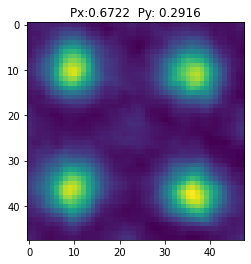

In [28]:
k = 10

plt.imshow(imgdata[k])
plt.title("Px:{}  Py: {}".format(Pxy[0, 0].round(4), Pxy[0, 1].round(4)))

Plot spatial map of polarization for the selected component

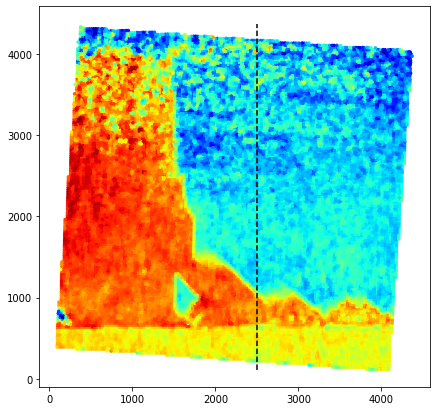

In [29]:
plt.figure(figsize=(7, 7))
plt.scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 0], cmap='jet', s=6)
plt.vlines(2500, xy_COM[:, 0].min(), xy_COM[:, 1].max(), linestyle='--')

Flatten image dimensions (so that we can images as inputs to BNN) 

In [30]:
n, h, w = imgdata.shape
imgdata = imgdata.reshape(n, h*w)
imgdata.shape

(23332, 2304)

Normalize image pixels:


In [31]:
imgdata = (imgdata - imgdata.mean()) / imgdata.std()

Use only half onf the data for training (the other half automatically becomes test/validation set):

In [32]:
Pxy_train = Pxy[xy_COM[:,1]<2500]
imgdata_train = imgdata[xy_COM[:,1]<2500]
xy_COM_train = xy_COM[xy_COM[:,1]<2500]
print(imgdata.shape, imgdata_train.shape, Pxy_train.shape)

(23332, 2304) (13174, 2304) (13174, 2)


Next we define utility functions for inference and prediction...

In [ ]:
def run_inference(model, args, rng_key,
                  X, Y, output_dim,
                  print_summary=False):
    """
    Runs the No-U-Turn Sampler (NUTS) for Hamiltonian Monte Carlo
    to infer the weights in bayesian neural network
    """
    kernel = NUTS(model)
    mcmc = MCMC(kernel, 
                args['num_warmup'], 
                args['num_samples'], 
                num_chains=args['num_chains'],
                chain_method='sequential')
    mcmc.run(rng_key, X, Y, args['num_hidden'], output_dim)
    if print_summary:
        mcmc.print_summary() 
    return mcmc.get_samples()


def predict(model, rng_key, samples,
            X, hidden_dim, output_dim,
            return_y=False):

    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    model_trace = handlers.trace(model).get_trace(X=X, y=None,
                                                  hidden_dim=hidden_dim,
                                                  output_dim=output_dim)
    if return_y:
        return model_trace['y']['value']
    model_trace_ = {}
    for k, val in model_trace.items():
        model_trace_[k] = val['value']
    return model_trace_

... and for building a simple BNN model

In [ ]:
def sample_weights(name, in_channels, out_channels):
    """Sampling weights tensor"""
    return numpyro.sample(name=name, fn=dist.Normal(
                loc=np.zeros((in_channels, out_channels)), 
                scale=np.ones((in_channels, out_channels))))
    
def sample_biases(name, channels):
    """Sampling bias vector"""
    return numpyro.sample(name=name, fn=dist.Normal(
                loc=np.zeros((channels)), scale=np.ones((channels))))
    
def bnn_layer(z, in_channels, out_channels, 
              w_name, b_name, nonlinearity=True, bias=True):
    """Creates a single BNN layer with non-linear activation"""
    z = np.matmul(z, sample_weights(w_name, in_channels, out_channels),
                  precision=jax.lax.Precision.HIGH)
    if bias:
        z = z + sample_biases(b_name, out_channels)
    if not nonlinearity:
         return z
    return np.tanh(z)#jax.nn.softplus(z)

def model(X, y, hidden_dim, output_dim):
    """
    Bayesian neural network with three layers: 

    Args:
        X: numpy array
            training samples
        y: numpy array
            targets (labels)
        hidden_dim: int
            number of neurons
        output_dim: int
            output dimensions
    """
    # Input dimensions
    input_dim = X.shape[-1]
    # Observation noise
    _obs = numpyro.sample("_obs", dist.Gamma(3., 1.))
    sigma_obs = 1 / np.sqrt(_obs)
    # Neural network
    z1 = bnn_layer(X, input_dim, hidden_dim, 'w1', 'b1', nonlinearity=True)
    z2 = bnn_layer(z1, hidden_dim, hidden_dim, 'w2', 'b2', nonlinearity=True)
    z3 = bnn_layer(z2, hidden_dim, output_dim, 'w3', 'b3', nonlinearity=False)
    # "Observe" data
    numpyro.sample("y", dist.Normal(z3, sigma_obs), obs=y)

Run inference to learn weights:

In [ ]:
args = {
    "num_chains": 6, # Number of chains for MCMC (runs sequentially)
    "num_hidden": 50, # Number of neurons in each layer of BNN
    "num_samples": 150, # Number of MCMC samples
    "num_warmup": 200 # number of warmup steps
}
# Learn model parameters
out_d = Pxy_train.shape[-1]
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, imgdata_train, Pxy_train, out_d)

sample: 100%|██████████| 350/350 [17:26<00:00,  2.99s/it, 1023 steps of size 6.43e-04. acc. prob=0.88]


In [ ]:
# np.save("/content/drive/My Drive/research/bnn/ferroic_samples_10chains_train_test.npy", samples)

Move generated samples to CPU (the prediction is fast but requires relatively large amount of RAM):

In [ ]:
samples = jax.device_put(samples, jax.devices("cpu")[0])

Use sampled weights to make a prediction on the entire image stack (contains both train and test sets):

In [ ]:
# get predictions
predict_fn = vmap(
    lambda samples, rng_key: predict(
        model, rng_key, samples, imgdata, 
        args['num_hidden'], 2,
        return_y=True)
)
predictions = predict_fn(
    samples, random.split(
        rng_key_predict, 
        args['num_samples'] * args['num_chains'])
)

Plot results:

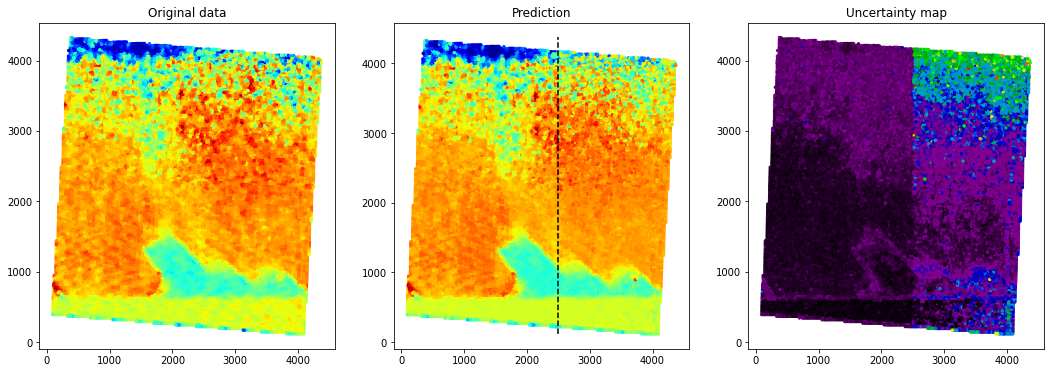

In [ ]:
xy_COM = onp.delete(dataset['xy'], idx_to_del, axis=0)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.scatter(xy_COM[:, 1],
            xy_COM[:, 0],
            c=Pxy[:, 1],
            cmap='jet', s=6)
ax2.scatter(xy_COM[:, 1],
            xy_COM[:, 0],
            c = np.mean(predictions, axis=0)[..., 1],
            cmap='jet', s=6)
ax2.vlines(2500, xy_COM[:, 0].min(), xy_COM[:, 1].max(), linestyle='--')
im = ax3.scatter(xy_COM[:, 1], 
                 xy_COM[:, 0], 
                 c=np.std(predictions, axis=0)[..., 1],
                 cmap='nipy_spectral', s=6)
ax1.set_title('Original data')
ax2.set_title('Prediction')
ax3.set_title('Uncertainty map')
plt.show()

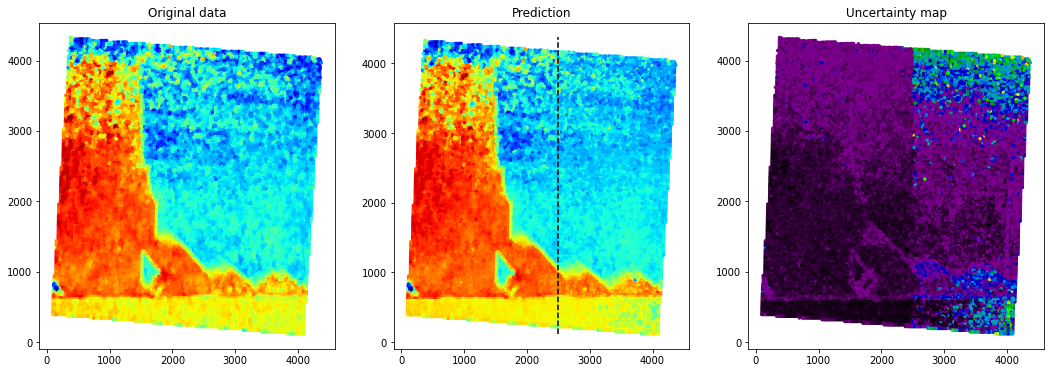

In [ ]:
xy_COM = onp.delete(dataset['xy'], idx_to_del, axis=0)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.scatter(xy_COM[:, 1],
            xy_COM[:, 0],
            c=Pxy[:, 0],
            cmap='jet', s=6)
ax2.scatter(xy_COM[:, 1],
            xy_COM[:, 0],
            c = np.mean(predictions, axis=0)[..., 0],
            cmap='jet', s=6)
ax2.vlines(2500, xy_COM[:, 0].min(), xy_COM[:, 1].max(), linestyle='--')

im = ax3.scatter(xy_COM[:, 1], 
                 xy_COM[:, 0], 
                 c=np.std(predictions, axis=0)[..., 0],
                 cmap='nipy_spectral', s=6)
ax1.set_title('Original data')
ax2.set_title('Prediction')
ax3.set_title('Uncertainty map')
plt.show()